## Ball Picking Challenge

### Part 1: Navigation

The aim is to program the robot for the first part of the challenge: follow the line from the beginning to the destination point. To do so, you need to reuse the abilities learnt in weeks 1-3; please feel free to reuse the code of those notebooks and exercises.

In [131]:
import packages.initialization
import pioneer3dx as p3dx
p3dx.init()
p3dx.sleep(2)
import cv2
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
p3dx.sleep(1)

Found ROS controller /pioneer3dx_9838_ip_172_31_42_132


In [132]:
MIN_WALL_THRESHOLD = 0.2 
MAX_WALL_THRESHOLD = 0.3
DEF_X_SPEED = 0.2 
DEF_YAW_SPEED = 0.25#0.15
lower_purple = numpy.array([135, 100, 80])
upper_purple = numpy.array([155, 255, 255])
lower_green = numpy.array([65, 50, 50])
upper_green = numpy.array([135, 255, 255])
lower_blue = numpy.array([110, 100, 100])
upper_blue = numpy.array([130, 255, 255])
lower_red = numpy.array([0, 100, 100])
upper_red = numpy.array([10, 255, 255])
WALLSIDE = 0
GREENSIDE = 0

def is_line_detected():
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower_purple, upper_purple)
    #mask[0:80, 0:150] = 0 # 0:50, 0:150??
    #plt.imshow(mask)
    M = cv2.moments(mask)
    if M['m00'] == 0:
        return False
    else:
        return True

def is_line_detected_close():
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower_purple, upper_purple)
    mask[0:80, 0:150] = 0 # 0:50, 0:150??
    #plt.imshow(mask)
    M = cv2.moments(mask)
    if M['m00'] == 0:
        return False
    else:
        return True


def follow_line():
    kp = 0.1
    width = p3dx.image.shape[1]
    print('Following the line')
    while not is_obstacle_detected() and not is_goal_detected():
        if is_green_detected():
            #print("green detected")
            area, cx, cy = green_centroid(p3dx.image, lower_green, upper_green)
            kp = 0.3
            linear = 1
        else:
            area, cx, cy = line_centroid(p3dx.image, lower_purple, upper_purple)
            kp = 0.1
            linear = 2
        area, cx, cy = line_centroid(p3dx.image, lower_purple, upper_purple)
        linear = 2
        if area > 0:
            err = cx - (width/2)
            angular = -kp*err
        else:
            angular = 0
        move(linear, angular)
    move(0,0)
    print('Stopped following the line')

#find obstacle
def is_obstacle_detected():
    leftSide, frontSide, rightSide = getSonars()
    if frontSide < MAX_WALL_THRESHOLD:
        print('Obstacle detected')
        return True
    else:
        return False

def getSonars():
    leftSide = min(p3dx.distance[0:3])
    frontSide = min(p3dx.distance[3:5])
    rightSide = min(p3dx.distance[5:])
    return leftSide, frontSide, rightSide

def is_green_detected():
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower_green, upper_green)
    mask[0:50, 0:150] = 0
    M = cv2.moments(mask)
    area = M['m00']
    if area > 0:
        return True
    else:
        return False
    
def move(V_robot,w_robot):
    r = 0.1953 / 2
    L = 0.33
    w_r = (2 * V_robot + L * w_robot) / (2*r)
    w_l = (2 * V_robot - L * w_robot) / (2*r)
    p3dx.move(w_l, w_r)

def is_blob_centered(lower, upper):
    area, cx, cy = color_blob(lower, upper)
    if area > 0 and cx >= 70 and cx < 80:
        return True
    else:
        return False

def is_blob_close(lower, upper):
    area, cx, cy = color_blob(lower, upper)
    if area > 0 and cy >= 90:
        return True
    else:
        return False

def getWall():
    l, f, r = getSonars()
    # move forward until an obstacle is detected at the front
    while f > MIN_WALL_THRESHOLD:
        move(DEF_X_SPEED,0)
        l, f, r = getSonars()
    # turn until the wall is detected by sonar 0
    if r > l:
        while p3dx.distance[0] > MAX_WALL_THRESHOLD:
            if f < l:
                yawSpeed = -DEF_YAW_SPEED * 3
            else:
                yawSpeed = -DEF_YAW_SPEED
            move(0,yawSpeed)
            l, f, r = getSonars()
    else:
        while p3dx.distance[7] > MAX_WALL_THRESHOLD:
            if f < r:
                yawSpeed = DEF_YAW_SPEED * 3
            else:
                yawSpeed = DEF_YAW_SPEED
            move(0,yawSpeed)
            l, f, r = getSonars()
    move(0,0)
    
def is_goal_detected():
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower_green, upper_green)
    mask[0:50, 0:150] = 0
    #plt.imshow(mask)
    M = cv2.moments(mask)
    area = M['m00']
    #print(area)
    if area > 700000:#746895
        return True
    else:
        return False

def green_centroid(image, lower, upper):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    mask[40:100, 0:150] = 0
    #plt.imshow(mask)
    M = cv2.moments(mask)
    area = M['m00']
    if area > 0:
        cx = int(M['m10']/area)
        cy = int(M['m01']/area)
    else:
        mask = cv2.inRange(hsv, lower, upper)
        mask[70:100, 0:150] = 0
        M = cv2.moments(mask)
        area = M['m00']
        if area > 0:
            cx = int(M['m10']/area)
            cy = int(M['m01']/area)
        else:
            mask = cv2.inRange(hsv, lower, upper)
            M = cv2.moments(mask)
            area = M['m00']
            if area > 0:
                cx = int(M['m10']/area)
                cy = int(M['m01']/area)
            else:
                cx = None
                cy = None
    return area, cx, cy

def line_centroid(image, lower, upper):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    #plt.imshow(mask,cmap='gray');
    mask[0:80, 0:150] = 0
    #plt.imshow(mask,cmap='gray');
    M = cv2.moments(mask)
    area = M['m00']
    if area > 0:
        cx = int(M['m10']/area)
        cy = int(M['m01']/area)
    else:
        mask = cv2.inRange(hsv, lower, upper)
        mask[0:50, 0:150] = 0
        M = cv2.moments(mask)
        area = M['m00']
        if area > 0:
            cx = int(M['m10']/area)
            cy = int(M['m01']/area)
        else:
            cx = None
            cy = None
    return area, cx, cy

def color_blob(lower, upper):
    hsv = cv2.cvtColor(p3dx.image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    M = cv2.moments(mask)
    area = M['m00']
    if area > 0:
        cx = int(M['m10']/area)
        cy = int(M['m01']/area)
    else:
        cx = None
        cy = None
    return area, cx, cy

def follow_wall(WALLSIDE):
    print('Following the wall')
    WALLSIDE = 0 # 1 is left -1 is right
    leftSide, frontSide, rightSide = getSonars()
    if leftSide < rightSide:
        WALLSIDE = 1
    else:
        WALLSIDE = -1
    while not is_line_detected_close():
        leftSide, frontSide, rightSide = getSonars()
        # by default, just move forward
        xSpeed = DEF_X_SPEED
        yawSpeed = 0
        # if we're getting too close to the wall with the front side...
        if frontSide < MAX_WALL_THRESHOLD or (WALLSIDE == 1 and rightSide < MAX_WALL_THRESHOLD) or (WALLSIDE == -1 and leftSide < MAX_WALL_THRESHOLD) :
            # go backward and turn right quickly (x4)
            xSpeed = -0.1
            yawSpeed = -DEF_YAW_SPEED * 4 * WALLSIDE
        else:
            # if we're getting too close to the wall with the left side...
            if (WALLSIDE == 1 and leftSide < MIN_WALL_THRESHOLD) or (WALLSIDE == -1 and rightSide < MIN_WALL_THRESHOLD):
                # move slowly forward (x0.5) and turn right
                xSpeed  = DEF_X_SPEED * 0.5
                yawSpeed = -DEF_YAW_SPEED * WALLSIDE
            else:
                # if we're getting too far away from the wall with the left side...
                if (WALLSIDE == 1 and leftSide > MAX_WALL_THRESHOLD) or (WALLSIDE == -1 and rightSide > MAX_WALL_THRESHOLD):
                    # move slowly forward (x0.5) and turn left
                    xSpeed  = DEF_X_SPEED * 0.5
                    yawSpeed = DEF_YAW_SPEED * WALLSIDE
        # Move the robot
        move(xSpeed,yawSpeed)
    move(0,0)
    return WALLSIDE
    print('Line detected')

def getLine(WALLSIDE):
    print('Getting Line')
    if WALLSIDE == 1:
        move(0.15, -0.35) # Besides, move forward slowly
        p3dx.sleep(numpy.pi/(2*0.35)) # Y = w * T --> T = Y/w
    elif WALLSIDE == -1:
        move(0.15, 0.35) # Besides, move forward slowly
        p3dx.sleep(numpy.pi/(2*0.35)) # Y = w * T --> T = Y/w
    WALLSIDE = 0
    move(0,0)
    print('Got Line')

p3dx.tilt(-0.47)
try:
    #print(getSonars())
    #print(is_goal_detected())
    #plt.imshow(p3dx.image)
    follow_line()
    getWall()
    getLine(follow_wall(WALLSIDE))
    follow_line()
    move(2,0)
    p3dx.sleep(0.8)
    move(0,0)
except KeyboardInterrupt:
    move(0,0)

Following the line
Obstacle detected
Stopped following the line
Following the wall
Getting Line
Got Line
Following the line
Stopped following the line


---
#### Try-a-Bot: an open source guide for robot programming
Developed by:
[![Robotic Intelligence Lab @ UJI](img/logo/robinlab.png "Robotic Intelligence Lab @ UJI")](http://robinlab.uji.es)

Sponsored by:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="http://www.ieee-ras.org"><img src="img/logo/ras.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.cyberbotics.com"><img src="img/logo/cyberbotics.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.theconstructsim.com"><img src="img/logo/theconstruct.png"></a>
</td>
</tr>
</table>

Follow us:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="https://www.facebook.com/RobotProgrammingNetwork"><img src="img/logo/facebook.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="https://www.youtube.com/user/robotprogrammingnet"><img src="img/logo/youtube.png"></a>
</td>
</tr>
</table>

B


(112200.0, 104, 48)

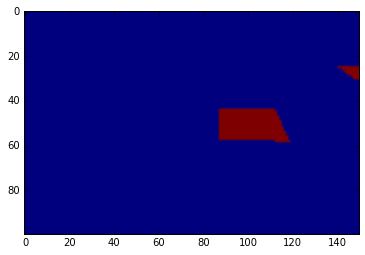

In [117]:
green_centroid(p3dx.image, lower_green, upper_green)

A


True

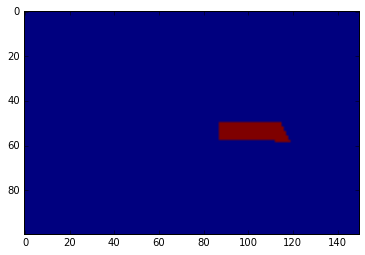

In [116]:
is_green_detected()